# **Detecting and Mitigating Age Bias on Credit Decisions Using a Hybrid Model for Loan Repayment Prediction**

# **Import the necessary libraries**

In [1]:
# Load all necessary packages
%pip install aif360
%matplotlib inline
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference", "Average odds difference"]

Note: you may need to restart the kernel to use updated packages.


0.1.36ubuntu1 is an invalid version and will not be supported in a future release
0.23ubuntu1 is an invalid version and will not be supported in a future release
2022-05-13 01:22:39.659105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 01:22:39.659133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# **loading the dataset, Dividing dataset into train and test dataset and Display datset shape**

NOTE: #This dataset also includes a protected feature attribute  "sex" which is not consider in this evaluation

In [2]:
german_dataset = GermanDataset(protected_attribute_names=['age'],
    privileged_classes=[lambda x: x >= 25], # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)
german_dataset_train, german_dataset_test = german_dataset.split([0.7], shuffle=True)
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]
german_dataset_train, german_dataset_vt = german_dataset.split([0.7], shuffle=True)
german_dataset_valid, german_dataset_test = german_dataset_vt.split([0.5], shuffle=True)
display(Markdown("#### Training Dataset shape"))
print(german_dataset_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(german_dataset_train.favorable_label, german_dataset_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(german_dataset_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(german_dataset_train.privileged_protected_attributes,
      german_dataset_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(german_dataset_train.feature_names)


#### Training Dataset shape

(700, 57)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['age']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'foreign_wor

# **Applying Logistic Regression on German original Dataset**

In [3]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(german_dataset_train.features)
y_train = german_dataset_train.labels.ravel()
w_train = german_dataset_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, sample_weight=german_dataset_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == german_dataset_train.favorable_label)[0][0]
german_dataset_train_pred = german_dataset_train.copy()
german_dataset_train_pred.labels = y_train_pred

# **Validating the orignal Dataset**

In [4]:
german_dataset_valid_pred = german_dataset_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(german_dataset_valid_pred.features)
y_valid = german_dataset_valid_pred.labels
german_dataset_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

german_dataset_test_pred = german_dataset_test.copy(deepcopy=True)
X_test = scale_orig.transform(german_dataset_test_pred.features)
y_test = german_dataset_test_pred.labels
german_dataset_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [5]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):

    fav_inds = german_dataset_valid_pred.scores > class_thresh
    german_dataset_valid_pred.labels[fav_inds] = german_dataset_valid_pred.favorable_label
    german_dataset_valid_pred.labels[~fav_inds] = german_dataset_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(german_dataset_valid,
                                             german_dataset_valid_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6932
Optimal classification threshold (no reweighing) = 0.6534


# **Calculating all the metrics for Orignal Dataset**

In [6]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    fav_inds = german_dataset_test_pred.scores > thresh
    german_dataset_test_pred.labels[fav_inds] = german_dataset_test_pred.favorable_label
    german_dataset_test_pred.labels[~fav_inds] = german_dataset_test_pred.unfavorable_label

    metric_test_bef = compute_metrics(german_dataset_test, german_dataset_test_pred,
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.6534


100%|██████████| 100/100 [00:00<00:00, 798.25it/s]

Balanced accuracy = 0.7110
Statistical parity difference = -0.1632
Disparate impact = 0.7478
Average odds difference = -0.0959
Equal opportunity difference = -0.0778
Theil index = 0.2473


# **Plotting all the metrics for Orignal dataset**

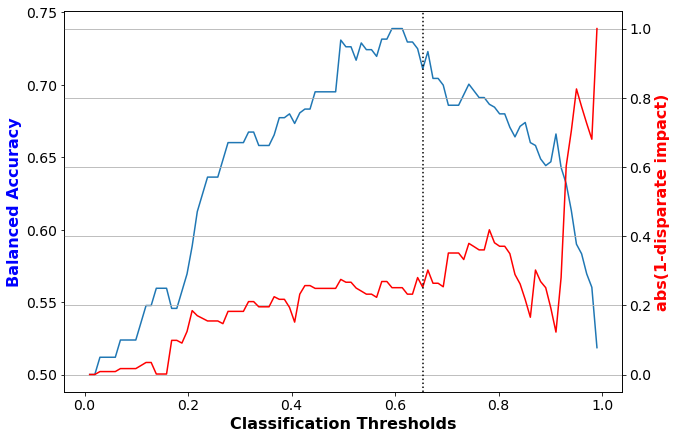

In [7]:
##abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
#However, for a classifier trained with original training data, 
##at the best classification rate, this is high. This implies unfairness.
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

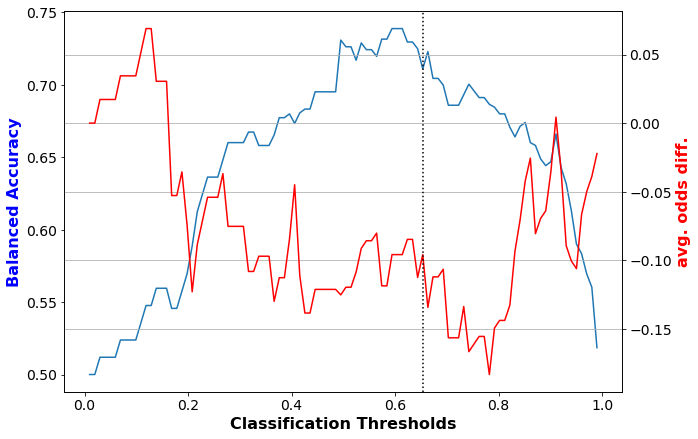

In [8]:
##average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

##However, for a classifier trained with original training data, at the best classification rate, 
##this is quite high. This implies unfairness.
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

# **Detection of Biasness**

In [9]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(german_dataset_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.126838


# **Mitigation of Biasness**

In [10]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(german_dataset_train)
dataset_transf_train = RW.transform(german_dataset_train)

In [11]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


# **Applying Logistics Regresssion on Transformed Data(Bias Mitigated Dataset)**

In [12]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [13]:
dataset_transf_test_pred = german_dataset_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

# **Calculate all the metrics for Transformed Data**

In [14]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(german_dataset_test, dataset_transf_test_pred,
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.6534


100%|██████████| 100/100 [00:00<00:00, 581.14it/s]

Balanced accuracy = 0.6944
Statistical parity difference = -0.0819
Disparate impact = 0.8701
Average odds difference = -0.0186
Equal opportunity difference = 0.0000
Theil index = 0.2576


# **Plot all the metrics for transformed data**

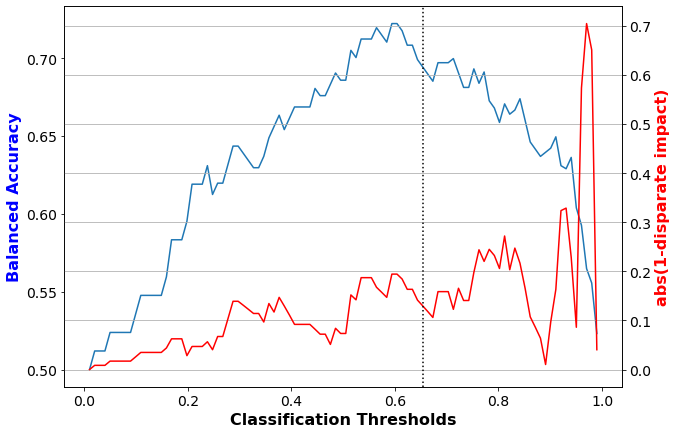

In [15]:
##abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

##For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

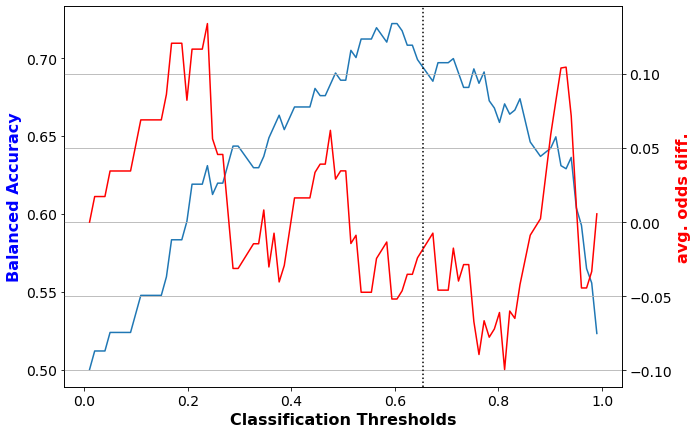

In [16]:
##average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

##For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.


fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)